# Saving to a SQL data base

This is an example of using a SQL database to store results from webscraping or API queries. 

A SQL database is an ideal way to store data that might become too large to fit into working memory, and setting things up this way makes it easy to continuously update a large data base with new information.

In [246]:
from requests import get
import pandas as pd
import time
from bs4 import BeautifulSoup
import os
import re
import sqlite3
import json


We'll start with a function that parses AP articles, along with a bit of code that conditionally creates a SQL database in the current directory if one doesn't exist.

In [251]:
def ap_parser(url):
    site = get(url)
    content = BeautifulSoup(site.content, "html.parser")
    timestamp = int(content.select_one('.Page-content bsp-timestamp').get('data-timestamp'))
    output = {
        'url' : site.url,
        'tags' : ', '.join([i.get('content') for i in content.select('meta[property="article:tag"]')]),
        'section' : ' '.join([i.get('content') for i in content.select('meta[property="article:section"]')]),
        'authors': ', '.join([i.get_text() for i in content.select('.Page-authors .Link')]),
        'article_text' : ' '.join([i.get_text() for i in content.select('.Page-content .RichTextBody p')]),
        'pubdate' : time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(timestamp/1000)), # the timestamp on AP articles is a unix epoch
        'headline' : ' '.join([i.get_text() for i in content.select('.Page-headline')])
    }
    return output

# check if articles table exists, create it if not:
conn = sqlite3.connect('./ap_articles.db')

cur = conn.cursor()
try: 
    cur.execute('SELECT * from articles limit 1')
    print("table exists")
except sqlite3.OperationalError:
    print("No articles table: creating")
    cur.execute('''
                CREATE TABLE articles(
                url text PRIMARY KEY,               
                tags text,
                section text,
                authors text,
                article_text text,
                pubdate text,
                headline text       
                )''')



table exists


From here, I'm just doing something similar to what we did in classwork 9-1: grabbing a sitemap, getting a list of articles and scraping each one. However, there are two key differences that make this script operate slightly differently from the code we've used elsewhere:

1. When building the list of links, the URLs are stored in a dictionary and then written to a .json file. The looping process for creating this dictionary has some logic to skip sitemaps that have already been retrieved.
2. When scraping articles, the results are placed in a SQL database called `ap_articles.db`. If an article was previously scraped, we'll skip it entirely.


In [259]:
sitemap = get('https://apnews.com/ap-sitemap.xml')


overall_sitemap = BeautifulSoup(sitemap.content, features="xml") 
# select all <loc> nodes
overall_nodes = overall_sitemap.select('loc')
# loop through the entire list and just get the link
sitemap_urls = [i.get_text() for i in overall_nodes]
sitemaps = [i for i in sitemap_urls if bool(re.search('2024|2025', i)) ]



### Listing URLs

In [253]:
# either load the list of links or create a new empty dictionary
if os.path.exists("ap_links.json") == False:
    article_urls = {}
else:
    with open('ap_links.json', 'r') as file:
        article_urls = json.load(file)
    for i in sitemaps:
        if sitemaps[0] in article_urls.keys():
            continue  # skip this iteration this key is already present in the links list
        else:
            # get the sitemap
            response = get(i)
            # parse the content as an XML document
            sitemap= BeautifulSoup(response.content, features="xml")
            # select all <loc> nodes
            url_nodes = sitemap.select('loc')
            urls = [i.get_text() for i in url_nodes]
            article_urls[i] = {
                'link': [i for i in urls if bool(re.search("/article/", i)) ]
            
                }
            time.sleep(.1)

# finally, write the results to a json file
with open("ap_links.json", "w") as f:
        json.dump(article_urls, f, indent=4)

I'll search through the articles for URLs that contain the string "inflation" and only retrieve those

In [254]:
r = re.compile("inflation")
relevant_urls = []
for v in article_urls.values():
    relevant_urls.extend(list(filter(r.search, v['link'])))
len(relevant_urls) # number of results

662

### Scraping articles

Finally, I'll make a loop to scrape AP articles and add them to my SQL table. The loop below has built in logic to skip over a URL if it already exists in my SQL data base, so this code ensures that I won't have to scrape an article if I've already retrieved it (even if I were to restart my kernel and run this loop all over again)

In [255]:
for url in relevant_urls:
    article_count = pd.read_sql(f"SELECT COUNT(*) as article_count from articles  where url = '{url}'", con=conn)
    if article_count['article_count'][0]==0:
        print("not found, scraping article", end='\r')
        try:
            article = ap_parser(url)
        except: 
            print("error encountered")
        finally:
            pd.DataFrame(article, index=[0]).to_sql(con = conn, name='articles', if_exists='append', index=False)
            time.sleep(.3)
    else:
        print('article found', end='\r')

How many articles do we have now? We can use `read_sql` to send an SQL statement to our database. The statement below would simply count all of the articles in the list:

In [182]:
pd.read_sql("SELECT COUNT(*) from articles", con=conn)

,COUNT(*)
0,662


Alternatively, you can use a statement like this to retrieve all of the data from a SQL table:

In [256]:
inflation_articles = pd.read_sql("SELECT * from articles", con=conn)
conn.close() # close the connection to the database once you've got the information you need

More importantly: if we were to revisit this table at a later point, re-running the script would only require us to update the data base for new articles. Otherwise, the steps above would just be skipped entirely. This setup allows me to incrementally build a very large database of articles.

From here, you could do something like make a plot of the total amount of inflation coverage from the AP for each month and then compare it to actual inflation rates. Or choose to scrape another outlet to see how coverage of economic news varies across sources, or use the text of individual articles for a text analysis.

C:\Users\neilb\AppData\Local\Temp\ipykernel_69332\3069613688.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  period_counts = inflation_articles.set_index('pubdate').resample('M').size().fillna(0)


<Axes: title={'center': 'AP Articles about inflation by month'}, xlabel='Month', ylabel='Number of articles'>

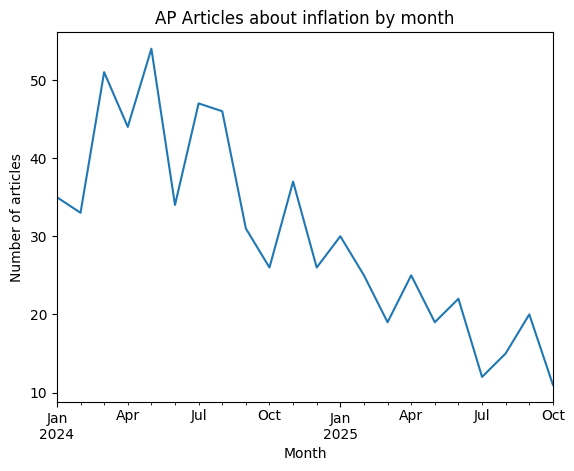

In [258]:
# count by month, and fill missing months with 0

inflation_articles['pubdate'] = pd.to_datetime(inflation_articles['pubdate'])
period_counts = inflation_articles.set_index('pubdate').resample('M').size().fillna(0)
period_counts.plot.line(xlabel='Month', ylabel='Number of articles', title='AP Articles about inflation by month')